In this notebook, we visualise the data for both raw and normalised cases. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Path_raw = '../../data/firstRound_Microplate_normFalse_formatSeq_logTrue.csv'
Path_normalised = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

df_raw = pd.read_csv(Path_raw)
df_normalised = pd.read_csv(Path_normalised)

In [3]:
df_raw

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,80.919700,52.402431,98.720440,61.622165,54.151485,45.499195,65.552569,18.514648
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,58.336880,40.072951,81.136200,42.042854,45.432032,41.005659,51.337763,14.673422
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,38.780700,28.831559,58.763330,24.487870,24.133637,25.596639,33.432289,12.378064
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,60.720820,43.093359,74.605290,38.641958,38.049577,31.608154,47.786526,14.992992
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,58.099540,45.913214,70.531620,44.352931,38.394865,43.641794,50.155661,10.883487
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,173,RBS_RP_54,prob random,TTTAAGATAGTCTTATACAT,TAGTCT,42.012270,30.349395,48.065647,23.192318,22.529527,19.020427,30.861597,10.716294
172,174,RBS_RP_55,prob random,TTTAAGAAAGTAGTATACAT,AAGTAG,35.855279,24.871063,47.282700,19.754875,20.914430,14.882341,27.260115,11.032482
173,175,RBS_RP_57,prob random,TTTAAGACCACGCTATACAT,CCACGC,27.895153,24.162037,39.250152,19.173251,19.669933,16.453214,24.433957,7.589869
174,176,RBS_RP_58,prob random,TTTAAGAGTAATGTATACAT,GTAATG,28.807363,22.799048,44.838864,18.105528,21.241526,16.135053,25.321230,9.596430


In [4]:
df_normalised

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,173,RBS_RP_54,prob random,TTTAAGATAGTCTTATACAT,TAGTCT,0.714643,0.842647,0.499893,0.416488,0.453764,0.260032,0.585487,0.184425
172,174,RBS_RP_55,prob random,TTTAAGAAAGTAGTATACAT,AAGTAG,0.496670,0.488540,0.471117,0.125964,0.320157,-0.182145,0.380490,0.159538
173,175,RBS_RP_57,prob random,TTTAAGACCACGCTATACAT,CCACGC,0.151373,0.437093,0.144887,0.071844,0.209971,-0.001291,0.203034,0.139725
174,176,RBS_RP_58,prob random,TTTAAGAGTAATGTATACAT,GTAATG,0.195634,0.333809,0.378132,-0.031925,0.348030,-0.036484,0.244736,0.169817


## AVERAGE Label Histogram

Text(0.5, 1.0, 'Normalised Average Label')

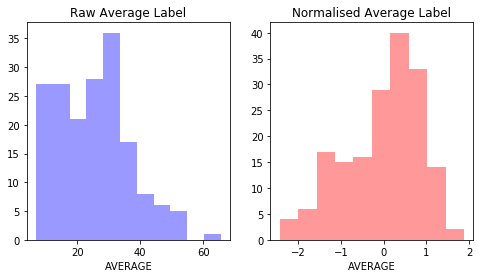

In [5]:
f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False)


sns.distplot(df_raw['AVERAGE'], kde=False, color="b", ax=axes[0])
axes[0].set_title('Raw Average Label')
sns.distplot(df_normalised['AVERAGE'], kde=False, color="r", ax=axes[1])
axes[1].set_title('Normalised Average Label')

## Replicates Distributions

Sorted by the average labels. x-axis represents sequences index with increasing average labels.

Text(0.5, 1.0, 'Normalised Replicates')

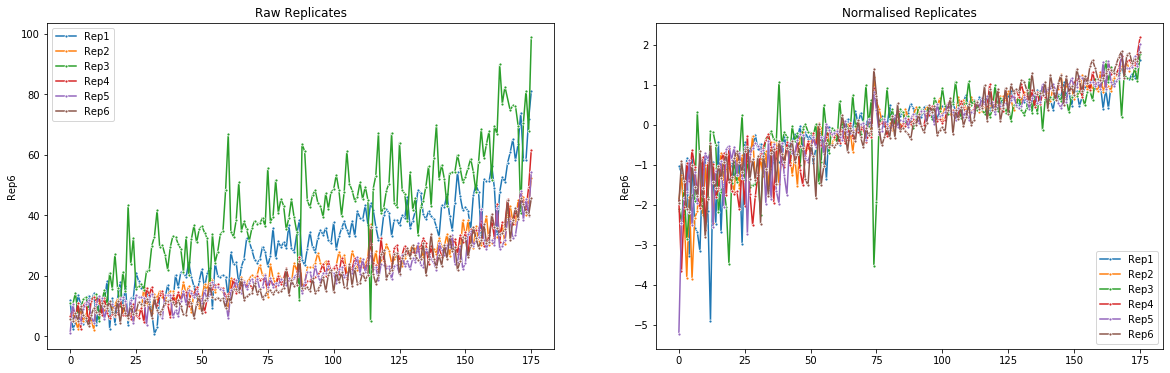

In [6]:
sorted_by_ave_df_raw = df_raw.sort_values(by = ['AVERAGE'])
sorted_by_ave_df_normalised = df_normalised.sort_values(by = ['AVERAGE'])

f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

for i in ['Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6']:
    sns.lineplot(range(len(sorted_by_ave_df_raw[i])), sorted_by_ave_df_raw[i], label = str(i), marker = '.', ax = axes[0])
    sns.lineplot(range(len(sorted_by_ave_df_normalised[i])), sorted_by_ave_df_normalised[i], label = str(i), marker = '.', ax = axes[1])
axes[0].set_title('Raw Replicates')
axes[1].set_title('Normalised Replicates')

Note the Z-score normalisation is in terms of each replicates, so if we sort each replicate and plot it, each replicates would like the similar, but note in this case, the x-axis does not represent the SAME sequence for each replicate.

Text(0.5, 1.0, 'Normalised Replicates, sorted by each replicate')

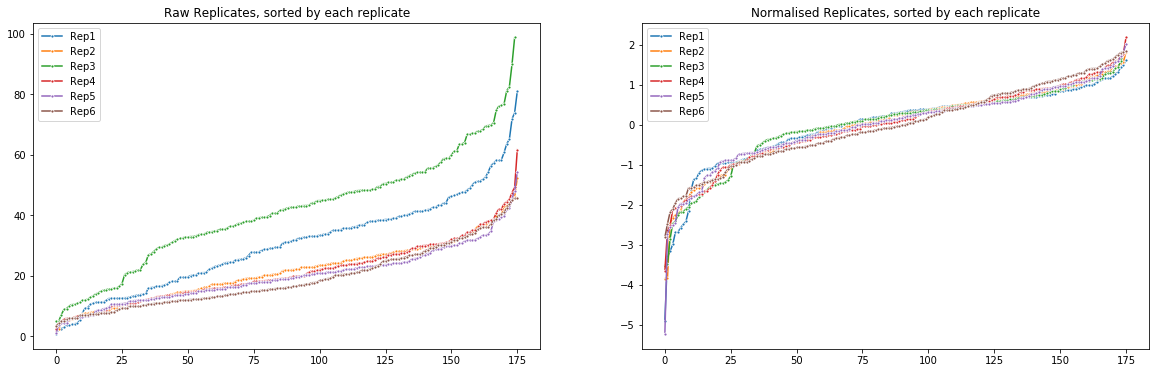

In [7]:
f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

for i in ['Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6']:
    sns.lineplot(range(len(df_raw[i])), np.sort(df_raw[i]), label = str(i), marker = '.', ax = axes[0])
    sns.lineplot(range(len(df_normalised[i])), np.sort(df_normalised[i]), label = str(i), marker = '.', ax = axes[1])
axes[0].set_title('Raw Replicates, sorted by each replicate')
axes[1].set_title('Normalised Replicates, sorted by each replicate')

## Violinplot

Text(0.5, 1.0, 'Normalised')

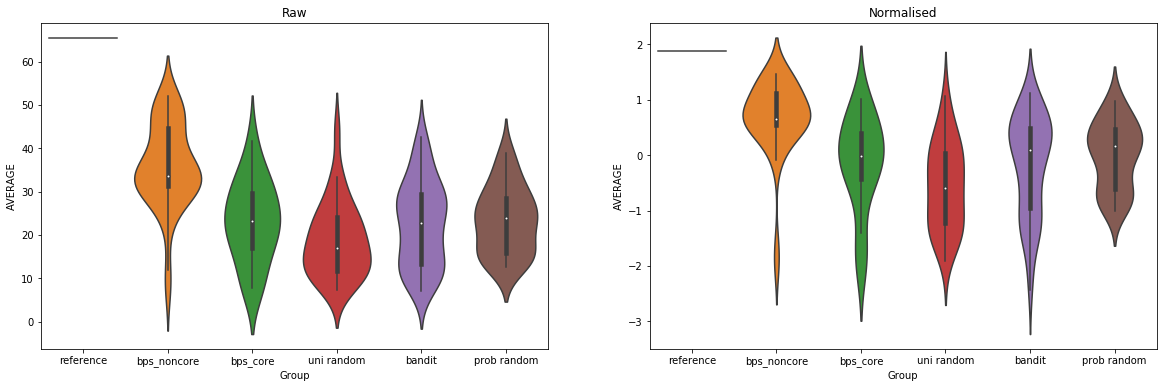

In [8]:
f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

sns.violinplot(x = 'Group', y = 'AVERAGE', data = df_raw, ax = axes[0])
sns.violinplot(x = 'Group', y = 'AVERAGE', data = df_normalised, ax = axes[1])
axes[0].set_title('Raw')
axes[1].set_title('Normalised')

Text(0.5, 1.0, 'Normalised')

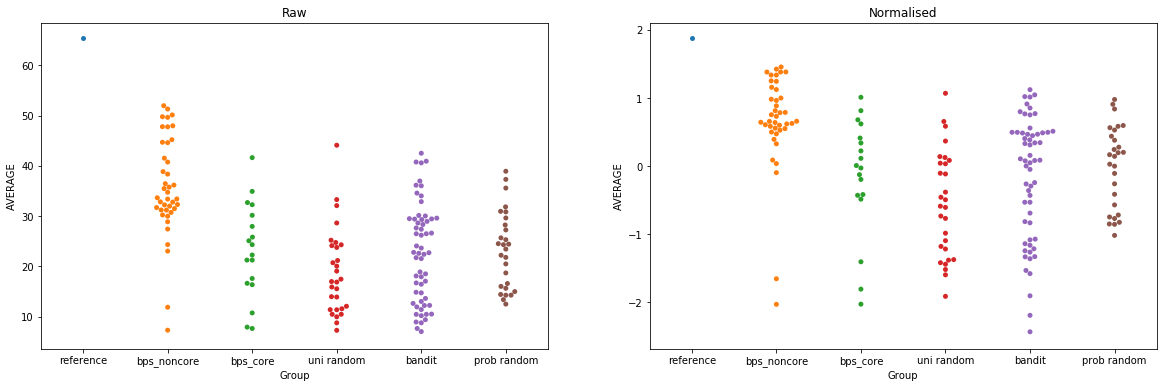

In [9]:
f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_raw, ax = axes[0])
sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_normalised, ax = axes[1])
axes[0].set_title('Raw')
axes[1].set_title('Normalised')